<a href="https://colab.research.google.com/github/Raghvender1205/AI_From_Scratch/blob/main/AutoEncoders/MaskedAutoEncoders/mae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import 
import sys
import os
import requests
from PIL import Image

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# Clone MAE Repository 
!pip install timm # PyTorch Image Models
!git clone https://github.com/facebookresearch/mae.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 7.2 MB/s 
     |████████████████████████████████| 163 kB 53.2 MB/s 
Cloning into 'mae'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39
Unpacking objects: 100% (39/39), done.


In [4]:
sys.path.append('./mae')

In [5]:
import models_mae

In [6]:
# Helper Functions
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def show_img(image, title=''):
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * STD + MEAN) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')

    return

def prepare_model(ckpt_dir, arch='mae_vit_large_patch16'):
    model = getattr(models_mae, arch)()
    # Load Model
    ckpt = torch.load(ckpt_dir, map_location='cpu')
    msg = model.load_state_dict(ckpt['model'], strict=False)
    print(msg)

    return model
    
def run_one_img(img, model):
    x = torch.tensor(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # Visualize MAE
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2*3) # (H, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    x = torch.einsum('nchw->nhwc', x)
    
    # Masked Image
    img_masked = x * (1 - mask)
    # MAE reconstruction pasted with patches
    img_paste = x * (1 - mask) + y * mask

    plt.rcParams['figure.figsize'] = [24, 24]
    plt.subplot(1, 4, 1)
    show_img(x[0], "original")
    plt.subplot(1, 4, 2)
    show_img(img_masked[0], "masked")
    plt.subplot(1, 4, 3)
    show_img(y[0], "reconstruction")
    plt.subplot(1, 4, 4)
    show_img(img_paste[0], "reconstruction + visible")

    plt.show()

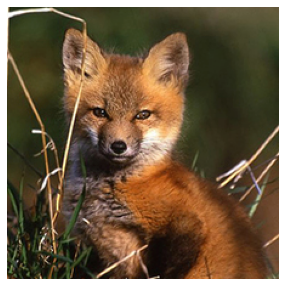

In [7]:
# Load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# Normalize by ImageNet mean and std
img = img - MEAN
img = img / STD

plt.rcParams['figure.figsize'] = [5, 5]
show_img(torch.tensor(img))